In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import locale
# print(locale.getpreferredencoding())

# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"

# locale.getpreferredencoding = getpreferredencoding

In [ ]:
pip install catboost

In [ ]:
# if "ValueError: numpy.dtype size changed, may indicate binary incompatibility.
# Expected 96 from C header, got 88 from PyObject" - just restart

from datetime import datetime, timedelta
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import Image
from scipy.ndimage import shift
import matplotlib.pyplot as plt
from scipy.stats import cauchy
import scipy.stats as stats
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import tensorflow as tf
import pickle
import keras
import torch
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import load_model
from keras.layers import Dense
from datetime import date
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import cupy as np
import os
import joblib
import seaborn as sns
import numpy as np2
import pandas as pd
import matplotlib
import random
import time
import math
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Let's write a function that returns a set of upper
#     and lower bounds + a set of all bounds

def range_prices(pa_t,pb_t,N_t):

    i_Bi = np.arange(N_t)
    bs_Bi = np.arange(pb_t, pa_t, - (pb_t - pa_t) / N_t)
    as_Bi = shift(bs_Bi.get(), - 1, cval = pa_t)
    pr_ranges = np.append(pb_t, as_Bi)

    return bs_Bi, as_Bi, pr_ranges

# since the set of prices is known, for a GIVEN tau, let us determine the prices-instants of time at which -
# - the reference bucket Z(s) is redefined.
# The moment of final zeroing after T final liquidity reset is not included in the set returned by the function

def z_list_t(tau, prices_c, mu_bucket, ind_in_):

    z_list = []
    for i in range(len(prices_c)):
        if i == 0:
            z_list.append(i)
            z_ = i
        else:
            if abs(ind_in_[i] - ind_in_[z_]) > tau:
                z_list.append(i)
                z_ = i
    z_list = np.asarray(z_list)

    return z_list

def x_Nd(_tau, _mu_bucket, pr0, range_prices_ex, a):

    x_ind_Z = np.digitize(pr0, range_prices_ex[2], right = True) - 1
    xi_ar = np.where(((np.tile(np.arange(_mu_bucket), (len(pr0),1)) > x_ind_Z.reshape(-1,1)) & (
        np.tile(np.arange(_mu_bucket), (len(pr0),1)) < x_ind_Z.reshape(-1,1) + _tau + 1)),a / (2 * _tau),
            np.where((np.tile(np.arange(_mu_bucket), (len(pr0),1)) < x_ind_Z.reshape(-1,1)) & (
                np.tile(np.arange(_mu_bucket), (len(pr0),1)) > x_ind_Z.reshape(-1,1) - _tau - 1),a / (2 * _tau),0))
    xi_ar[np.arange(len(pr0)), x_ind_Z] = 1 - np.sum(xi_ar,axis=1)

    return xi_ar



In [ ]:
# 2023-2024 year fact DEX - 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 [USDC / ETH 0,05%]

dfs = []

for i in range(1, 7 + 1):
    file_name = f"data_1st_05_p{i}.csv"
    df = pd.read_csv(file_name)
    dfs.insert(0, df)

df_23_24 = pd.concat(dfs, axis=0, ignore_index=True)

In [ ]:
df_23_24['transaction.timestamp'] = df_23_24['transaction.timestamp'].astype(int)
df_23_24['amount0'] = df_23_24['amount0'].astype(float)
df_23_24['amount1'] = df_23_24['amount1'].astype(float)
df_23_24['transaction.timestamp'] = pd.to_datetime(df_23_24['transaction.timestamp'], unit = 's')
df_23_24['Day_Year'] = 0

for y_dt in df_23_24['transaction.timestamp'].dt.year.unique():

    indx_ = np2.where(df_23_24['transaction.timestamp'].dt.year.values == y_dt)[0]
    df_23_24.loc[indx_,'Day_Year'] = np2.asarray((df_23_24.iloc[indx_][
        'transaction.timestamp'] - datetime(y_dt, 1, 1)).dt.days + 1)
    print(y_dt, len(df_23_24.loc[indx_]))

df_23_24.set_index('transaction.timestamp', inplace=True)

df_23_24 = df_23_24[abs(df_23_24['amount1']) > 0]
df_23_24 = df_23_24[abs(df_23_24['amount0']) > 0]

df_23_24['price'] = abs(df_23_24['amount0'] / df_23_24['amount1'])
df_23_24['vol'] = abs(df_23_24['amount0'])

2024 1707666
2023 1231302


drop: 623 | iter: 2


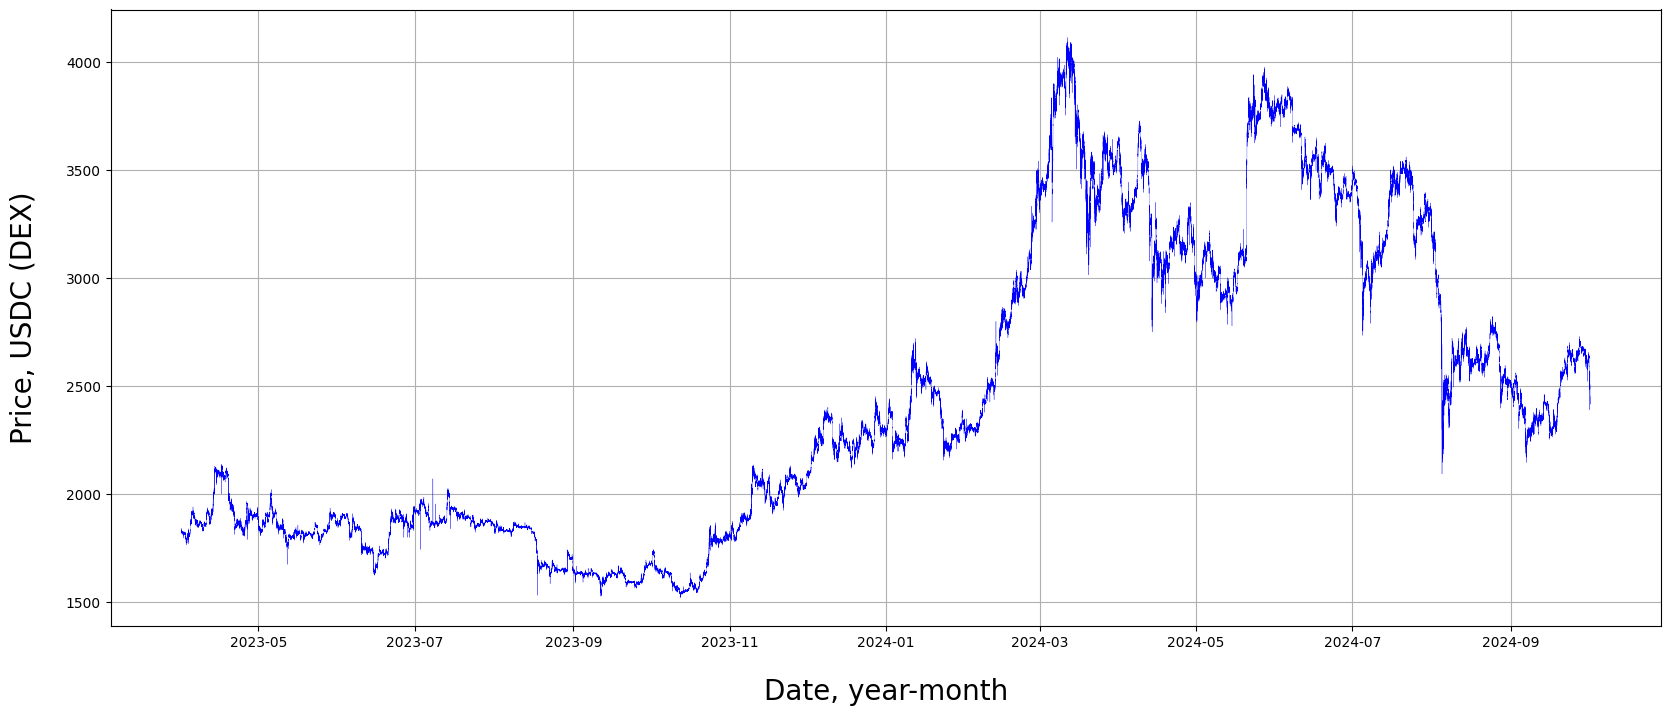

In [ ]:
# Remove price outliers
drop_indx = np.zeros((1,11))
k_di = 0
j_di = 0

while drop_indx.shape[1] > 10:

    delt_pr = 1 - df_23_24['price'][:-1].values / df_23_24['price'][1:].values

    drop_indx = np2.sort(
                    np2.hstack((
                        np2.where(delt_pr > 0.05), np2.where(delt_pr < -0.05))))

    df_23_24 = df_23_24[~df_23_24.index.isin(df_23_24.index.values[drop_indx][0])]
    k_di += drop_indx.shape[1]
    j_di +=1

print('drop:', k_di, "|", "iter:", j_di)

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df_23_24['price'], linewidth = 0.2, color='blue', alpha = 1)

ax.set_xlabel('Date, year-month', labelpad = 20, fontsize = 20)
ax.set_ylabel('Price, USDC (DEX)', labelpad = 20, fontsize = 20)
ax.grid()
plt.show()

In [ ]:
# Train & OOT df

df_train = df_23_24[((df_23_24.index.normalize() < '2024-07-01') & (
    df_23_24.index.normalize() > '2023-03-31'))].copy() # 2Q2023-3Q2024
df_oot = df_23_24[((df_23_24.index.normalize() >= '2024-09-01') & (
    df_23_24.index.normalize() < '2024-10-01'))].copy() # 3Q2024

cols_ = ['price', 'vol']

df_train = df_train[cols_]
df_train = df_train.iloc[::-1].copy()

df_oot = df_oot[cols_]
df_oot = df_oot.iloc[::-1].copy()

In [ ]:
# Find the moments of the change of epoch under tau = 5
#  for given the parameters

n_rg = 650    # number of ranges. select so that the upper bound must be greater than the maximum value by (apprx_n // 2 +1)* av_w
tau = 0           # tau parametr
av_w = 10         # range width
mu_bucket = n_rg
cu_pr = np.mean(df_train['price']).item() # select distribution center
price_test = np.array(df_train['price'])
prices_c = price_test.reshape(1, -1)
price_t_up = n_rg * av_w # upper bound of the simulated pool. must be greater than the max hist price!
price_t_down = 0 # lower bound of the simulated pool. must be less than the max hist price!
range_prices_ = range_prices(price_t_down, price_t_up, mu_bucket)

pr = prices_c[0] # it is possible to submit a set of price arrays. now just one
ind_in = np.digitize(pr, range_prices_[2], right = True)
z_moments_t = z_list_t(tau, pr.get(), mu_bucket, ind_in.get()) # moments of capital relocation for tau = 5. without the last one!

z_list = z_moments_t
z_list = np.hstack((z_list, len(df_train['price']))) # add the last moment
pr_total = pr

ep_n = np.zeros((len(df_train))).astype(int) # the epoch of each observation

for i in tqdm(range(0, len(z_list) - 1)):
    ep_n[z_list[i]: z_list[i + 1] + 1] = int(i)

100%|██████████| 324686/324686 [00:36<00:00, 8940.80it/s]


In [ ]:
ep_time_ar = df_train.index[z_moments_t.get()]
ep_time_ar = np2.diff(ep_time_ar).astype('timedelta64[h]')
print('average duration of an epoch:', '\n',
      np.mean(ep_time_ar), '\n',
      np.round(np.mean(np.diff(z_list)),1), 'prices')

average duration of an epoch: 
 0 hours 
 184.2 prices


eth nan check: [0 0]
btc nan check: [0 0]


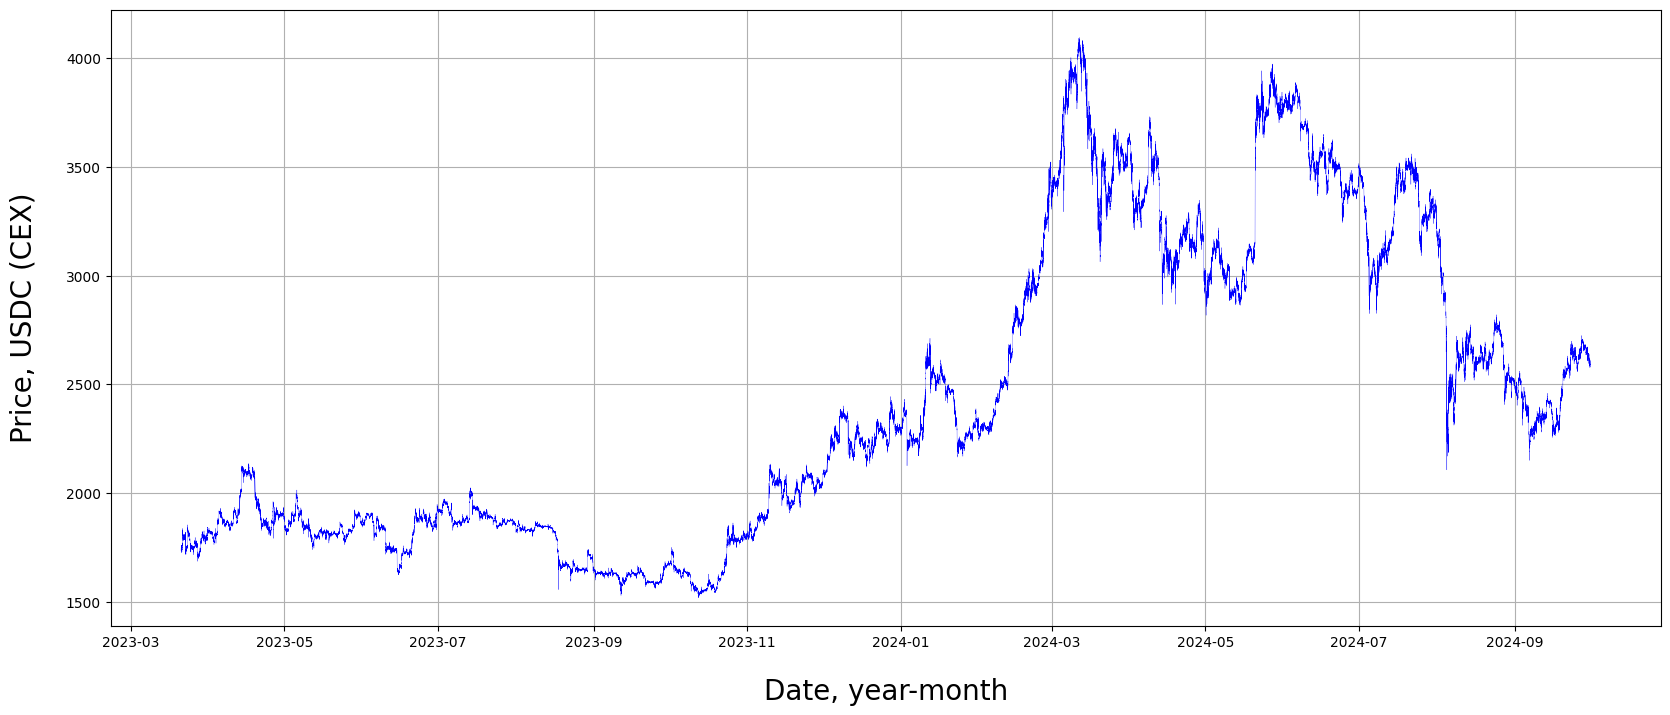

In [ ]:
# Each moment of the change of epochs corresponds to the state of the market (info from CEX).
# This is "market" data for a pair not from a specific DEX pool (data for training the model).
# We will load the data (OHLCV) and create additional features based on the existing data.

btc_df = pd.read_csv('btc_usdc_23_24_1m_F.csv')
eth_df = pd.read_csv('eth_usdc_23_24_1m_F.csv')

btc_df['time'] = pd.to_datetime(btc_df['time'])
eth_df['time'] = pd.to_datetime(eth_df['time'])

btc_df = btc_df.set_index(['time'])
eth_df = eth_df.set_index(['time'])

btc_df = btc_df[btc_df.index.normalize() > '2023-03-20'].copy()
eth_df = eth_df[eth_df.index.normalize() > '2023-03-20'].copy()

btc_df['volume'].replace(0, 0.00000001, inplace = True)
eth_df['volume'].replace(0, 0.00000001, inplace = True)

print('eth nan check:', pd.isna(eth_df).sum().values)
print('btc nan check:', pd.isna(btc_df).sum().values)

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(eth_df['close'], linewidth = 0.2, color='blue', alpha = 1)

ax.set_xlabel('Date, year-month', labelpad = 20, fontsize = 20)
ax.set_ylabel('Price, USDC (CEX)', labelpad = 20, fontsize = 20)
ax.grid()
plt.show()

In [ ]:
# Feature generation functions

def rolling_window_np(a, window):

    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    st = np2.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

    return st

def data_transform(df, macd_1, macd_2, std_long, std_short):

    t_min = macd_1
    eth_k_min = df['close'].ewm(span = 12 * t_min, adjust = False, min_periods = 12 * t_min).mean()
    eth_d_min = df['close'].ewm(span = 26 * t_min, adjust = False, min_periods = 26 * t_min).mean()
    eth_macd_min = eth_k_min - eth_d_min
    eth_macd_s_min = eth_macd_min.ewm(span = 9 * t_min, adjust = False, min_periods = 9 * t_min).mean()
    eth_macd_h_min = eth_macd_min - eth_macd_s_min
    df['k_min'] = eth_k_min
    df['d_min'] = eth_d_min
    df['macd_min'] = eth_macd_min
    df['signal_min'] = eth_macd_s_min
    df['del_min'] = eth_macd_h_min

    t_h = macd_2
    eth_k_h = df['close'].ewm(span = 12 * t_h, adjust = False, min_periods = 12 * t_h).mean()
    eth_d_h = df['close'].ewm(span = 26 * t_h, adjust = False, min_periods = 26 * t_h).mean()
    eth_macd_h = eth_k_h - eth_d_h
    eth_macd_s_h = eth_macd_h.ewm(span = 9 * t_h, adjust = False, min_periods = 9 * t_h).mean()
    eth_macd_h_h = eth_macd_h - eth_macd_s_h

    df['k_h'] = eth_k_h
    df['d_h'] = eth_d_h
    df['macd_h'] = eth_macd_h
    df['signal_h'] = eth_macd_s_h
    df['del_h'] = eth_macd_h_h

    std_per = std_long
    df[f'std_{std_long}'] = 0
    df[f'std_{std_long}'].iloc[std_per - 1:] = np.std(rolling_window_np(df.close.values, std_per), 1)

    std_per = std_short
    df[f'std_{std_short}'] = 0
    df[f'std_{std_short}'].iloc[std_per - 1:] = np.std(rolling_window_np(df.close.values, std_per), 1)

    df['std_d'] = df[f'std_{std_short}'] - df[f'std_{std_long}']

    df = df.iloc[(26 + 9) * t_h - 2:,:]

    return df

def find_nearest_d(array, value):

    idx = (np2.abs(array - value)).argmin()

    return array[idx], idx

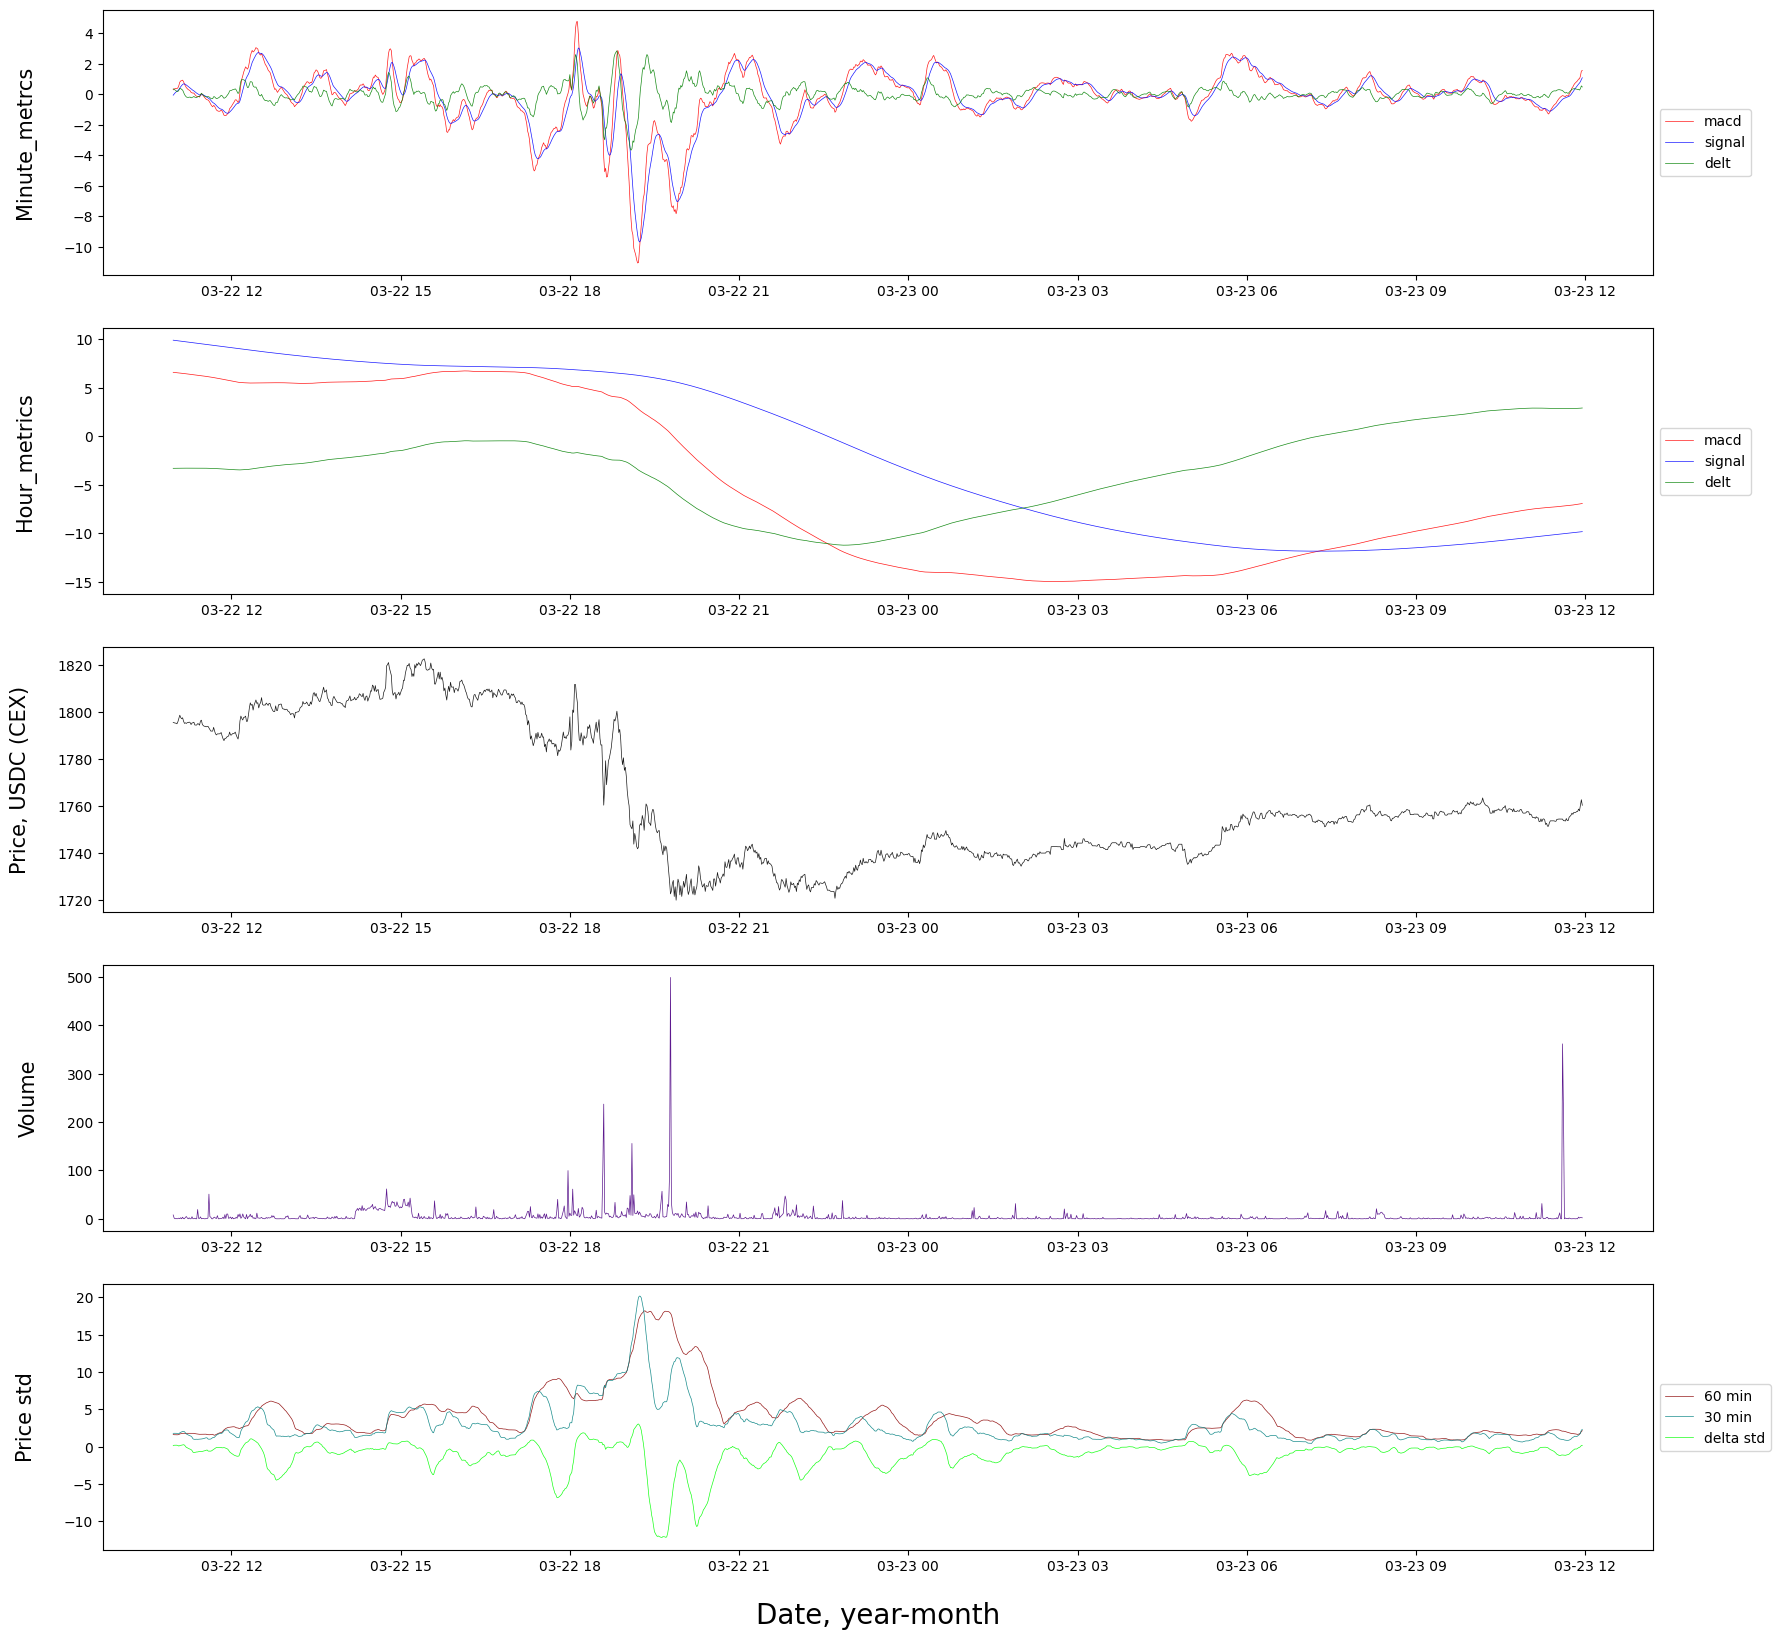

In [ ]:
# Show illustrations of generated features on the entire train sample

macd_1_ = 1
macd_2_ = 60
std_long_ = 60
std_short_ = 30

eth_df_ill = data_transform(eth_df, macd_1_, macd_2_, std_long_, std_short_)
btc_df_ill = data_transform(btc_df, macd_1_, macd_2_, std_long_, std_short_)

ind_ = 1500
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(20, 20))

ax5.set_ylabel('Price std', labelpad = 20, fontsize = 15)
ax5.plot(eth_df_ill.iloc[:ind_,:]['std_60'], linewidth=0.5, color='darkred', alpha = 0.9, label = '60 min')
ax5.plot(eth_df_ill.iloc[:ind_,:]['std_30'], linewidth=0.5, color='teal', alpha = 0.9, label = '30 min')
ax5.plot(eth_df_ill.iloc[:ind_,:]['std_d'], linewidth=0.5, color='lime', alpha = 0.9, label = 'delta std')

ax4.set_ylabel('Volume', labelpad = 20, fontsize = 15)
ax4.plot(eth_df_ill.iloc[:ind_,:]['volume'], linewidth=0.5, color='indigo', alpha = 0.9, label = 'vol')

ax3.set_ylabel('Price, USDC (CEX)', labelpad = 20, fontsize = 15)
ax3.plot(eth_df_ill.iloc[:ind_,:]['close'], linewidth=0.5, color='black', alpha = 0.9, label = 'price')

ax2.set_ylabel('Hour_metrics', labelpad = 20, fontsize = 15)
ax2.plot(eth_df_ill.iloc[:ind_,:]['macd_h'], linewidth=0.5, color='red', alpha = 0.9, label = 'macd')
ax2.plot(eth_df_ill.iloc[:ind_,:]['signal_h'], linewidth=0.5, color='blue', alpha = 0.9, label = 'signal')
ax2.plot(eth_df_ill.iloc[:ind_,:]['del_h'], linewidth=0.5, color='green', alpha = 0.9, label = 'delt')

ax1.set_ylabel('Minute_metrcs', labelpad = 20, fontsize = 15)
ax1.plot(eth_df_ill.iloc[:ind_,:]['macd_min'], linewidth=0.5, color='red', alpha = 0.9, label = 'macd')
ax1.plot(eth_df_ill.iloc[:ind_,:]['signal_min'], linewidth=0.5, color='blue', alpha = 0.9, label = 'signal')
ax1.plot(eth_df_ill.iloc[:ind_,:]['del_min'], linewidth=0.5, color='green', alpha = 0.9, label = 'delt')

ax1.legend(title = "" ,bbox_to_anchor = (1.0, .65), loc = 'upper left')
ax2.legend(title = "" ,bbox_to_anchor = (1.0, .65), loc = 'upper left')
ax5.legend(title = "" ,bbox_to_anchor = (1.0, .65), loc = 'upper left')

ax5.set_xlabel('Date, year-month', labelpad = 20, fontsize = 20)
plt.show()

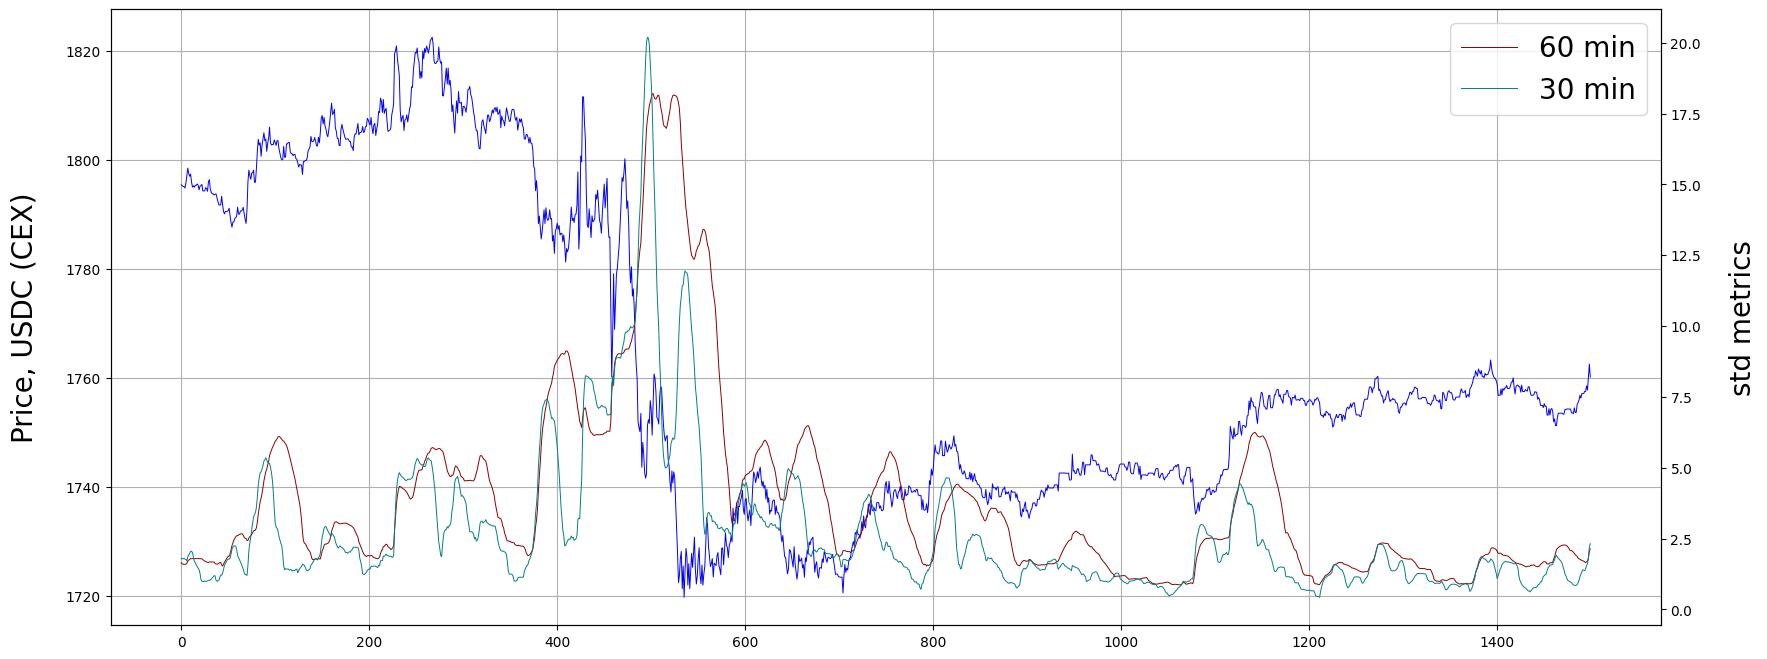

In [ ]:
# volatility feature

fig, host = plt.subplots(figsize=(20, 8))
par1 = host.twinx()

host.plot(eth_df_ill.iloc[:ind_,:]['close'].values, "blue", linewidth = 0.7)
par1.plot(eth_df_ill.iloc[:ind_,:]['std_60'].values, "darkred", linewidth = 0.7, label = '60 min')
par1.plot(eth_df_ill.iloc[:ind_,:]['std_30'].values, "teal", linewidth = 0.7, label = '30 min')

host.set_ylabel('Price, USDC (CEX)', labelpad = 20, fontsize = 20)
par1.set_ylabel('std metrics', labelpad = 20, fontsize = 20)
plt.legend(prop={'size':20})
host.grid()
plt.show()

In [ ]:
def V_init_max(mu_bucket, pa_Bi, pb_Bi):

    V_Bi = np.zeros((mu_bucket + 2, 6)) # 2D matrix with the number of buckets+2 to represent prices above/below the range
    V_Bi[:,5] = np.arange(mu_bucket + 2) # Let's number the buckets. 0th and last hypothetical
    V_Bi[1:-1,4] = np.asarray(pa_Bi) # upper limit of the bucket
    V_Bi[1:-1,3] = np.asarray(pb_Bi) # lower limit of the bucket
    V_Bi[1:-1,2] = 0 # fixed liquidity

    return V_Bi

def V_2d_max(price, range_prices_, V_m, L_cur):

    ind_in_ = np.digitize(price, range_prices_, right = True)#.item()

    V_m[1:ind_in_, 1] = 0
    V_m[1:ind_in_, 0] = 1 / np.sqrt(V_m[1:ind_in_, 4]) - 1 / np.sqrt(V_m[1:ind_in_,3])

    V_m[ind_in_ + 1:-1, 1] = np.sqrt(V_m[ind_in_ + 1:-1,3]) - np.sqrt(V_m[ind_in_ + 1:-1,4])
    V_m[ind_in_ + 1:-1, 0] = 0

    sqrt_price = np.sqrt(price)
    V_m[ind_in_, 1] = sqrt_price - np.sqrt(V_m[ind_in_,4])
    V_m[ind_in_, 0] = 1 / sqrt_price - 1/ np.sqrt(V_m[ind_in_,3])

    V_m[1:-1,2] = L_cur
    V_m[:,:2] *= V_m[:, 2, np.newaxis]

    return V_m


def V_3d_max(prices, ind_in_func, V_m, L_cur, _gamma):

    ind_in = ind_in_func
    V_Bi2_0 = np.tile(V_m, (len(ind_in), 1, 1))

    n_V = L_cur.shape[0]
    chunk_size = 10

    result_shape = (n_V, V_Bi2_0.shape[0], V_Bi2_0.shape[1], V_Bi2_0.shape[2])
    ret_ep_total = np.zeros(n_V)

    for i_V in range(0, n_V, chunk_size):

        chunk_slice = slice(i_V, i_V + chunk_size)
        V_Bi2_chunk = np.tile(V_Bi2_0, (chunk_size, 1, 1, 1))

        ind_up_ = V_Bi2_chunk[:, :, :, 5] < ind_in.reshape(-1, 1)
        ind_dwn_ = V_Bi2_chunk[:, :, :, 5] > ind_in.reshape(-1, 1)
        ind_in_ = V_Bi2_chunk[:, :, :, 5] == ind_in.reshape(-1, 1)

        V_Bi2_chunk[:, :, :, 1][ind_up_] = 0
        V_Bi2_chunk[:, :, :, 0][ind_up_] = (
            1 / np.sqrt(V_Bi2_chunk[:, :, :, 4][ind_up_]) -
            1 / np.sqrt(V_Bi2_chunk[:, :, :, 3][ind_up_]))

        V_Bi2_chunk[:, :, :, 1][ind_dwn_] = (
            np.sqrt(V_Bi2_chunk[:, :, :, 3][ind_dwn_]) -
            np.sqrt(V_Bi2_chunk[:, :, :, 4][ind_dwn_]))
        V_Bi2_chunk[:, :, :, 0][ind_dwn_] = 0

        V_Bi2_chunk[:, :, :, 1][ind_in_] = (
            np.tile(np.sqrt(prices), chunk_size) -
            np.sqrt(V_Bi2_chunk[:, :, :, 4][ind_in_]))
        V_Bi2_chunk[:, :, :, 0][ind_in_] = (
            1 / np.tile(np.sqrt(prices), chunk_size) -
            1 / np.sqrt(V_Bi2_chunk[:, :, :, 3][ind_in_]))

        V_Bi2_chunk[:, :, 1:-1, 2] = np.repeat(
            L_cur[chunk_slice, np.newaxis, :], prices.shape[0], axis=1)

        np.multiply(
            V_Bi2_chunk[:, :, :, :2],
            V_Bi2_chunk[:, :, :, 2:3],
            out=V_Bi2_chunk[:, :, :, :2])

        ret_ep = np.diff(V_Bi2_chunk[:, :, 1:-1, :2], axis=1)
        ret_ep = np.maximum(ret_ep, 0)

        ret_ep[:,:,:,0] *= prices[-1]
        ret_ep = np.sum(ret_ep, axis=(1, 2, 3)) * _gamma

        ret_ep_total[chunk_slice] = ret_ep

        # del V_Bi2_chunk
        # np.get_default_memory_pool().free_all_blocks()

    return ret_ep_total

def V_3d_max_LP(prices, ind_in_func, V_m, L_cur, Li_ep_LP, _gamma, TYPE_M = 0, DYN_W = False):

    ind_in = ind_in_func
    V_Bi2_0 = np.tile(V_m, (len(ind_in), 1, 1))

    n_V = L_cur.shape[0]
    chunk_size = n_V

    ratio_L = np.where(Li_ep_LP > L_cur, 1, Li_ep_LP / L_cur) # end14-03
    ratio_Lw = Li_ep_LP / L_cur
    result_shape = (n_V, V_Bi2_0.shape[0], V_Bi2_0.shape[1], V_Bi2_0.shape[2])

    for i_V in range(0, n_V, chunk_size):

        chunk_slice = slice(i_V, i_V + chunk_size)
        V_Bi2_chunk = np.tile(V_Bi2_0, (chunk_size, 1, 1, 1))

        ind_up_ = V_Bi2_chunk[:, :, :, 5] < ind_in.reshape(-1, 1)
        ind_dwn_ = V_Bi2_chunk[:, :, :, 5] > ind_in.reshape(-1, 1)
        ind_in_ = V_Bi2_chunk[:, :, :, 5] == ind_in.reshape(-1, 1)

        V_Bi2_chunk[:, :, :, 1][ind_up_] = 0
        V_Bi2_chunk[:, :, :, 0][ind_up_] = (
            1 / np.sqrt(V_Bi2_chunk[:, :, :, 4][ind_up_]) -
            1 / np.sqrt(V_Bi2_chunk[:, :, :, 3][ind_up_]))

        V_Bi2_chunk[:, :, :, 1][ind_dwn_] = (
            np.sqrt(V_Bi2_chunk[:, :, :, 3][ind_dwn_]) -
            np.sqrt(V_Bi2_chunk[:, :, :, 4][ind_dwn_]))
        V_Bi2_chunk[:, :, :, 0][ind_dwn_] = 0

        V_Bi2_chunk[:, :, :, 1][ind_in_] = (
            np.tile(np.sqrt(prices), chunk_size) -
            np.sqrt(V_Bi2_chunk[:, :, :, 4][ind_in_]))
        V_Bi2_chunk[:, :, :, 0][ind_in_] = (
            1 / np.tile(np.sqrt(prices), chunk_size) -
            1 / np.sqrt(V_Bi2_chunk[:, :, :, 3][ind_in_]))

        V_Bi2_chunk[:, :, 1:-1, 2] = np.repeat(
            L_cur[chunk_slice, np.newaxis, :], prices.shape[0], axis=1)

        np.multiply(
            V_Bi2_chunk[:, :, :, :2],
            V_Bi2_chunk[:, :, :, 2:3],
            out=V_Bi2_chunk[:, :, :, :2])

        ret_ep = V_Bi2_chunk[:, :, 1:-1, :2].copy()
        ret_ep[:,:,:,0] *= prices[-1]

        if DYN_W and TYPE_M == 0:
            w_ep = ret_ep.copy()
            w_LP_ep = np.sum(ratio_Lw * np.sum(w_ep[0,-1,:,:], axis = 1), axis = 1)
        elif DYN_W and TYPE_M == 1:
            w_ep = ret_ep.copy()
            w_ep = np.sum(w_ep[:,-1,:,:].reshape(n_rg, 2), axis=1, keepdims=True)
            w_LP_ep = np.sum(ratio_Lw * w_ep.T, axis = 1, keepdims=True)
        else:
            w_LP_ep = 0

        ret_ep = np.diff(ret_ep, axis=1)
        ret_ep = np.maximum(ret_ep, 0)

        ret_ep = np.sum(ret_ep, axis = 1) * _gamma
        ret_ep_pool = np.sum(ret_ep)
        ret_ep = np.sum(ret_ep, axis = 2)
        ret_ep = np.sum(ratio_L * ret_ep, axis = 1)

        # del V_Bi2_chunk
        # np.get_default_memory_pool().free_all_blocks()

    return ret_ep, ret_ep_pool, w_LP_ep, ratio_Lw#, V_Bi2_chunk#, V_Bi2_0, V_Bi2_chunk, i_V

def Li_Ei_max(price_upd, W, xi_array, ind_in, V_1):

    L_ar = np.zeros(xi_array.shape)
    Wx = W * xi_array
    p_up = price_upd
    ind_up = ind_in[0] - 1
    L_ar[:,:ind_up] = Wx[:,:ind_up] / p_up * np.sqrt(V_1[:,4][1:ind_up + 1] * V_1[
        :,3][1:ind_up + 1]) / (np.sqrt(V_1[:,3][1:ind_up + 1]) - np.sqrt(V_1[:,4][1:ind_up + 1]))
    L_ar[:,ind_up:] = Wx[:,ind_up:] / (np.sqrt(V_1[:,3][ind_up + 1:-1]) - np.sqrt(
        V_1[:,4][ind_up + 1:-1]))

    if p_up != V_1[:,3][ind_up + 1]:
        x_ = (np.sqrt(V_1[:,3][ind_up + 1]) * np.sqrt(p_up)) / (np.sqrt(V_1[:,3][ind_up + 1]) - np.sqrt(p_up))
        y_ = 1/(np.sqrt(p_up) - np.sqrt(V_1[:,4][ind_up + 1]))
        L_ar[:,ind_up] = Wx[:,ind_up] / (p_up +x_ / y_) * x_

    return L_ar

# main functions
def v3_model_max(W_init, price_set, xi_array, _mu_bucket,
                 range_prices_func_0, range_prices_func_1,range_prices_func_2,
                 ind_in_func, _gamma):

    i = 0
    W_ = W_init
    V_0 = V_init_max(_mu_bucket, range_prices_func_1, range_prices_func_0)

    V_2d_ep = V_2d_max(price_set[0], range_prices_func_2, V_0, 1)
    Li_ep = Li_Ei_max(price_set[0], W_, xi_array, ind_in_func, V_2d_ep)
    V_3d_ep = V_3d_max(price_set, ind_in_func, V_0, Li_ep, _gamma)

    return V_3d_ep

def v3_model_LP_max(W_init, W_init_LP, price_set, xi_array_opt, LP_array, _mu_bucket,
                 range_prices_func_0, range_prices_func_1,range_prices_func_2,
                 ind_in_func, _gamma, TYPE_M = 0, DYN_W = False):# add one optim xi_ar pool

    i = 0
    W_ = W_init
    V_0 = V_init_max(_mu_bucket, range_prices_func_1, range_prices_func_0)
    V_2d_ep = V_2d_max(price_set[0], range_prices_func_2, V_0, 1)

    Li_ep = Li_Ei_max(price_set[0], W_, xi_array_opt, ind_in_func, V_2d_ep)
    Li_ep_LP = Li_Ei_max(price_set[0], W_init_LP, LP_array, ind_in_func, V_2d_ep)

    V_3d_ep = V_3d_max_LP(price_set, ind_in_func, V_0, Li_ep, Li_ep_LP, _gamma, TYPE_M, DYN_W)

    return V_3d_ep

def find_and_check_nearest(array, value, threshold=0.1):

    array = np.asarray(array)
    idx = np.abs(array - value).argmin()
    nearest_value = array[idx]

    is_within_threshold = abs(nearest_value / value - 1) <= threshold

    return nearest_value, idx, is_within_threshold

def generate_normalized_vectors(m, k, distribution='uniform'):

    if distribution == 'uniform':
        vectors = np.random.uniform(0, 1, (m, k+1))
    elif distribution == 'normal':
        vectors = np.random.normal(0, 1, (m, k+1))
    elif distribution == 'exponential':
        vectors = np.random.exponential(1, (m, k+1))
    else:
        raise ValueError("Unsupported distribution")

    normalized_vectors = np.maximum(vectors / vectors.sum(axis=1, keepdims=True), 1e-60)

    return normalized_vectors

def x_Nd_best(tau, mu_bucket, p0, range_prices_2, best_str):

    x_ind_Z = np.digitize(p0, range_prices_2, right = True) - 1
    xi_arange = np.tile(np.arange(mu_bucket), (best_str.shape[0], 1))
    xi_ar = np.tile(np.zeros(mu_bucket), (best_str.shape[0], 1))

    if tau != 0:
        u_r = np.where((xi_arange > x_ind_Z.reshape(-1,1)) & (xi_arange < x_ind_Z.reshape(-1,1) + tau + 1))[0]
        xi_ar[np.where((xi_arange > x_ind_Z.reshape(-1,1)) & (xi_arange < x_ind_Z.reshape(-1,1) + tau + 1))] = ratio_right_best(u_r, best_str)
        u_l = np.where((xi_arange < x_ind_Z.reshape(-1,1)) & (xi_arange > x_ind_Z.reshape(-1,1) - tau - 1))[0]
        xi_ar[np.where((xi_arange < x_ind_Z.reshape(-1,1)) & (xi_arange > x_ind_Z.reshape(-1,1) - tau - 1))] = ratio_left_best(u_l, best_str)
    xi_ar[np.where(xi_arange == x_ind_Z.reshape(-1,1))] = 1 - np.sum(xi_ar, axis = 1)

    return xi_ar, best_str

def ratio_right_best(u_, best_str):

    n_list = []
    k = 0

    for bucket_r in np.split(u_, (np.where(np.diff(u_) > 0)[0] + 1).tolist()):
        ar = best_str[k][1:len(bucket_r) + 1] / 2
        if k == 0:
            ar_T = ar
        else:
            ar_T = np.concatenate((ar_T, ar))
        k += 1

    return ar_T

def ratio_left_best(u_, best_str):

    n_list = []
    k = 0

    for bucket_l in np.split(u_, (np.where(np.diff(u_) > 0)[0] + 1).tolist()):
        ar = np.flip(best_str[k][1:len(bucket_l) + 1]) / 2
        if k == 0:
            ar_T = ar
        else:
            ar_T = np.concatenate((ar_T, ar))
        k+=1

    return ar_T

def plot_dist(tau_, str_epoch):

    x_str = np.arange(2 * tau_ + 1)
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.plot(x_str.get(), str_epoch.get(), color = 'r')
    plt.bar(x_str.get(), str_epoch.get())
    plt.xticks(range(0, 2 * tau_ + 1))
    plt.xlabel("Tau buckets", fontsize = 20)
    plt.ylabel("Capital allocation strategy, USDC", fontsize = 20)

    plt.show()

def normalize_predictions(predictions):

    predictions[predictions == 0] = 1e-60
    predictions_normalized = predictions / np.sum(predictions, axis=1, keepdims=True)

    return predictions_normalized

def sliding_windows_(prices_, vols_, m_):

    assert len(prices_) == len(vols_), "Array lengths must match"

    if m_ == 2:
        prices_windows = np2.lib.stride_tricks.sliding_window_view(prices_.get(), m_)
        vol_windows = np2.lib.stride_tricks.sliding_window_view(vols_.get(), m_)
        vol_windows = vol_windows.copy()
        vol_windows[:, 0] = 0

        prices_windows = np.asarray(prices_windows)
        vol_windows = np.asarray(vol_windows)

    else:
        indices = [i_ * (m_ - 1) for i_ in range((len(prices_) - 1) // (m_ - 1))]
        indices.append(len(prices_) - (len(prices_) - indices[-1] - 1))
        prices_windows = [prices_[i_:i_ + m_].copy() for i_ in indices[:-1]]
        vol_windows = [vols_[i_:i_ + m_].copy() for i_ in indices[:-1]]

        prices_windows[-1] = prices_[indices[-1] - 1:]
        vol_windows[-1] = vols_[indices[-1] - 1:]

        for vw in vol_windows:
            vw[0] = 0

    return prices_windows, vol_windows

def V_3d_max_el(prices, ind_in_func, V_m, L_cur):

    ind_in = ind_in_func
    V_Bi2_0 = np.tile(V_m, (len(ind_in), 1, 1))
    V_Bi2 = np.tile(V_Bi2_0, (L_cur.shape[0], 1, 1, 1))

    ind_up_ = V_Bi2[:,:,:,5] < ind_in.reshape(-1,1)
    ind_dwn_ = V_Bi2[:,:,:,5] > ind_in.reshape(-1,1)
    ind_in_ = V_Bi2[:,:,:,5] == ind_in.reshape(-1,1)

    V_Bi2[:,:,:,1][ind_up_] = 0
    V_Bi2[:,:,:,0][ind_up_] = 1 / np.sqrt(V_Bi2[:,:,:,4][ind_up_]) - 1 / np.sqrt(V_Bi2[:,:,:,3][ind_up_])

    V_Bi2[:,:,:,1][ind_dwn_] = np.sqrt(V_Bi2[:,:,:,3][ind_dwn_]) - np.sqrt(V_Bi2[:,:,:,4][ind_dwn_])
    V_Bi2[:,:,:,0][ind_dwn_] = 0

    V_Bi2[:,:,:,1][ind_in_] = np.tile(np.sqrt(prices), L_cur.shape[0]) - np.sqrt(V_Bi2[:,:,:,4][ind_in_])
    V_Bi2[:,:,:,0][ind_in_] = 1 / np.tile(np.sqrt(prices), L_cur.shape[0]) - 1 / np.sqrt(V_Bi2[:,:,:,3][ind_in_])

    V_Bi2[:,:,1:-1,2] = np.repeat(L_cur[:, np.newaxis, :], prices.shape[0], axis=1)
    V_Bi2[:, :, :, :2] = (V_Bi2[:, :, :, :2] * V_Bi2[:, :, :, 2:3]).copy()

    return V_Bi2

def v3_model_max_el(W_init, price_set, xi_array, _mu_bucket,
                 range_prices_func_0, range_prices_func_1,range_prices_func_2,
                 ind_in_func, _gamma):

    i = 0
    W_ = W_init
    V_0 = V_init_max(_mu_bucket, range_prices_func_1, range_prices_func_0)

    V_2d_ep = V_2d_max(price_set[0], range_prices_func_2, V_0, 1)
    Li_ep = Li_Ei_max(price_set[0], W_, xi_array, ind_in_func, V_2d_ep)
    V_3d_ep = V_3d_max_el(price_set, ind_in_func, V_0, Li_ep)

    ret_ep = np.sum(np.maximum(V_3d_ep[:, -1, 1:-1, :2] - V_3d_ep[:, 0, 1:-1, :2], 0), axis = 1)
    ret_ep[:,0] *= price_set[-1]
    ret_ep = np.sum(ret_ep, axis = 1) * _gamma

    return ret_ep

def sliding_windows(prices_, vols_, m_):# m_ > 1!

    assert len(prices_) == len(vols_), "Array lengths must match"

    if m_ == 2:
        prices_windows = np.lib.stride_tricks.sliding_window_view(prices_, m_)
        vol_windows = np.lib.stride_tricks.sliding_window_view(vols_, m_)
        vol_windows = vol_windows.copy()
        vol_windows[:, 0] = 0
    else:
        indices = [i_ * (m_ - 1) for i_ in range((len(prices_) - 1) // (m_ - 1))]
        indices.append(len(prices_) - (len(prices_) - indices[-1] - 1))
        prices_windows = [prices_[i_:i_ + m_].copy() for i_ in indices[:-1]]
        vol_windows = [vols_[i_:i_ + m_].copy() for i_ in indices[:-1]]

        prices_windows[-1] = prices_[indices[-1] - 1:]
        vol_windows[-1] = vols_[indices[-1] - 1:]

        for vw in vol_windows:
            vw[0] = 0

    return prices_windows, vol_windows

def x_Nd_best_pool(mu_bucket, _apprx_n, _cu_pr_ep, range_prices_2, best_str):

    x_ind_Z = np.digitize(_cu_pr_ep, range_prices_2, right = True) - 1
    xi_arange = np.tile(np.arange(mu_bucket), (best_str.shape[0], 1))
    xi_ar = np.tile(np.zeros(mu_bucket), (best_str.shape[0], 1))
    center_index = _apprx_n // 2

    u_r = np.where((xi_arange >= x_ind_Z.reshape(-1,1)) & (xi_arange <= x_ind_Z.reshape(-1,1) + center_index))
    xi_ar[u_r] = ratio_right_best_pool(u_r[0], best_str, center_index)
    u_l = np.where((xi_arange < x_ind_Z.reshape(-1,1)) & (xi_arange > x_ind_Z.reshape(-1,1) - center_index - 1))
    xi_ar[u_l] = ratio_left_best_pool(u_l[0], best_str, center_index)

    return xi_ar

def ratio_right_best_pool(u_, best_str, _center_index):

    ar_T = np.flip(best_str[:,:_center_index + 1], axis = 1).flatten()

    return ar_T

def ratio_left_best_pool(u_, best_str, _center_index):

    ar_T = np.flip(best_str[:,_center_index + 1:], axis = 1).flatten()

    return ar_T


In [ ]:
w_tst_list = []
fin_pool_check = 0
fact_pool_check = 0
fact_pool_Mf_check = 0

chunk_size_t = 10
tvl = 140000000
W_initial = tvl
W_LP = 1000000
gas_pr = 20
gamma = 0.0005
scen = 1500
ep_scen = 10000
max_var = 10
min_var = 0.01
apprx_n = 401
var_set = np.linspace(min_var, max_var, scen)
acc_modPool = 0.05
var_modPool = max_var
r_d = 3

x = np.linspace(-r_d, r_d, apprx_n)
mu_step = 0.5
mu_minmax = 3
mu_range = np.arange(-mu_minmax, mu_minmax + mu_step, mu_step)

epsilon = 1e-60
var_set_gpu = np.asarray(var_set)
sigma_gpu = np.sqrt(var_set_gpu)

i_total = 0
res_array_tst = np.zeros((len(z_list) + 10, 1 + 5 + tau + 1 + 45))

In [ ]:
# OOT
df_oot.head()

,price,vol
transaction.timestamp,,
2024-09-01 00:00:11,2512.141000,2.512141
2024-09-01 00:00:11,2512.140000,0.502428
2024-09-01 00:00:23,2514.657478,478.479848
2024-09-01 00:00:35,2514.660356,138.322496
2024-09-01 00:00:35,2514.661181,36.459023


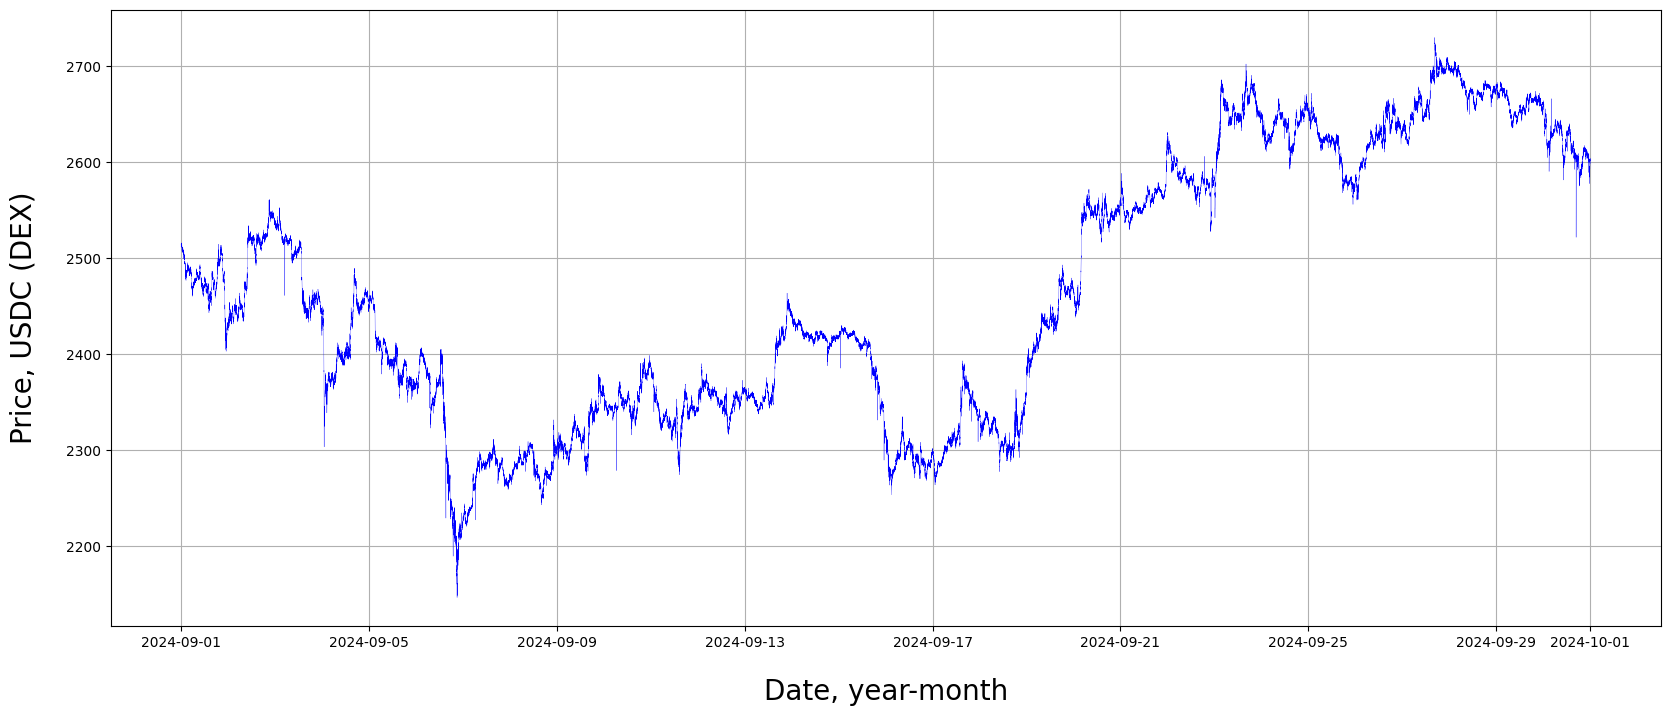

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df_oot['price'], linewidth = 0.2, color='blue', alpha = 1)

ax.set_xlabel('Date, year-month', labelpad = 20, fontsize = 20)
ax.set_ylabel('Price, USDC (DEX)', labelpad = 20, fontsize = 20)
ax.grid()
plt.show()

In [ ]:
# Find the moments of the change of epoch under tau = 0
#  for given the parameters on OOT

# cu_pr_oot = np.mean(df_oot['price']).item() # select distribution center
price_test_oot = np.array(df_oot['price'])
prices_c_oot = price_test_oot.reshape(1, -1)
range_prices_oot = range_prices_

pr_oot = prices_c_oot[0] # it is possible to submit a set of price arrays. now just one
ind_in_oot = np.digitize(pr_oot, range_prices_oot[2], right = True)
z_moments_t_oot = z_list_t(tau, pr_oot.get(), mu_bucket, ind_in_oot.get()) # moments of capital relocation for tau = 5. without the last one!

z_list_oot = z_moments_t_oot
z_list_oot = np.hstack((z_list_oot, len(df_oot['price']))) # add the last moment
pr_total_oot = pr_oot

ep_n_oot = np.zeros((len(df_oot))).astype(int) # the epoch of each observation

for i in tqdm(range(0, len(z_list_oot) - 1)):
    ep_n_oot[z_list_oot[i]: z_list_oot[i + 1] + 1] = int(i)

100%|██████████| 16667/16667 [00:01<00:00, 8966.28it/s]


In [ ]:
ep_time_ar = df_oot.index[z_moments_t_oot.get()]
ep_time_ar = np2.diff(ep_time_ar).astype('timedelta64[m]')
print('average duration of an epoch:', '\n',
      np.mean(ep_time_ar), '\n',
      np.round(np.mean(np.diff(z_list_oot)),1), 'prices')

average duration of an epoch: 
 2 minutes 
 8.1 prices


In [ ]:
un_vector = np.zeros(tau + 1)
un_vector[0] = 1 / (2* tau + 1)
un_vector[1:] = 2 * un_vector[0]
un_ar = np.tile(un_vector, (tau+1, 1))

combined_str = np.stack((un_ar,un_ar), axis=0)

In [ ]:
fin_pool_check = 0
fact_pool_check = 0
fact_pool_Mf_check = 0

W_LP = 1000000
tvl = 140000000
W_initial = tvl

epsilon = 1e-60
var_set_gpu = np.asarray(var_set)
sigma_gpu = np.sqrt(var_set_gpu)

i_total = 0
res_array_tst = np.zeros((pr_total_oot.shape[0], 4))

range_prices_ep = range_prices_oot

In [ ]:
# mu&var oot elastic fast

fin_pool_check = 0
fact_pool_check = 0
fact_pool_Mf_check = 0

W_LP = 1000000
tvl = 140000000
W_initial = tvl

epsilon = 1e-60
var_set_gpu = np.asarray(var_set)
sigma_gpu = np.sqrt(var_set_gpu)

i_total = 0
res_array_tst = np.zeros((pr_total_oot.shape[0], 4))

range_prices_ep = range_prices_oot

for i in tqdm(range(0, len(z_list_oot) - 1)):

    fact_return_ep_total = np.asarray(df_oot['vol'].values[z_list_oot[i].item(): z_list_oot[i + 1].item() + 1])
    price_test_total = np.asarray(pr_total_oot[z_list_oot[i]: z_list_oot[i + 1] + 1])

    buckets_price, buckets_vol = sliding_windows_(price_test_total, fact_return_ep_total, 2)

    i_tst = 0

    prices_c_ep = price_test_total.flatten()

    for bucket in buckets_price[:]:

        fact_return_ep = np.sum(np.asarray(buckets_vol[i_tst])) * gamma
        price_test = np.asarray(bucket)

        cu_pr_ep = np.mean(price_test)
        m_r = 0
        while cu_pr_ep - av_w * (apprx_n // 2 + 1) < 0:
            cu_pr_ep += av_w
            m_r += 1

        i_tst += 1
        i_total += 1

        prices_c_ep = price_test.flatten()

        res_array_tst[i_total, 0] = fact_return_ep
        fact_pool_check += fact_return_ep

        ind_in_ep = np.digitize(prices_c_ep, range_prices_ep[2], right = True)

        mu_find = False

        for indx_m, mu in enumerate(mu_range):

            if mu_find == False:

                capacity_all = stats.norm.pdf(x.get()[None, :], mu.item(), sigma_gpu.get()[:, None])
                capacity_all /= capacity_all.sum(axis=1, keepdims=True)
                xi_ar_list_0 = np.asarray(capacity_all)
                xi_ar_list = np.maximum(x_Nd_best_pool(mu_bucket, apprx_n, cu_pr_ep,
                                                   range_prices_ep[2], xi_ar_list_0), epsilon)

                res_mu = find_and_check_nearest(v3_model_max_el(W_initial, prices_c_ep, xi_ar_list, mu_bucket, range_prices_ep[0],
                range_prices_ep[1], range_prices_ep[2], ind_in_ep, gamma), fact_return_ep, threshold=0.1)

                mu_find = res_mu[2].item()

                if mu_find:

                    res_array_tst[i_total, 1] = res_mu[0].item()
                    fin_pool_check += res_mu[0].item()
                    res_array_tst[i_total, 2] = mu.item()
                    res_array_tst[i_total, 3] = var_set_gpu[res_mu[1].item()]

        if not mu_find:

            res_array_tst[i_total, 2] = 1000

        if i_total % 1000 == 0:

            print(fin_pool_check, fact_pool_check)
            pd.DataFrame(res_array_tst.get()).to_excel('drive/MyDrive/vega/upd_copy/p2_fast_OOT_ARRAY_ELASTIC_100.xlsx')

print(fin_pool_check, fact_pool_check)
pd.DataFrame(res_array_tst.get()).to_excel('drive/MyDrive/vega/upd_copy/p2_fast_OOT_ARRAY_ELASTIC_100.xlsx')

  0%|          | 0/55 [00:00<?, ?it/s]

8496.902275583048 8591.869280372008
17942.13633926366 18171.0360056345


  2%|▏         | 1/55 [02:53<2:36:09, 173.51s/it]

28864.0001748537 29227.64046022195


  4%|▎         | 2/55 [05:19<2:19:05, 157.47s/it]

43064.052356909226 43565.62215267451


  5%|▌         | 3/55 [06:24<1:39:41, 115.04s/it]

58522.66732179343 59411.98770344896
71003.95608266523 72090.3084597858
83089.31251668595 84238.0960960204


  7%|▋         | 4/55 [10:44<2:26:32, 172.40s/it]

99103.75067374714 100412.8686160619
117188.02746395435 118645.72128338137
131745.29208170943 133328.49635923136
143502.53520142767 145165.1943900855
153954.1456936073 156123.3912041809


  9%|▉         | 5/55 [18:10<3:45:59, 271.19s/it]

171400.46572296415 173780.66048479054
184227.92009556358 186874.75019504098
193062.41248415934 195788.17242883108


 13%|█▎        | 7/55 [22:29<2:24:11, 180.24s/it]

218859.01446409526 222370.91077159005
233953.72246486868 237554.80816119935
240375.71750532772 244052.34313622635


 15%|█▍        | 8/55 [26:16<2:32:55, 195.23s/it]

249513.1332614051 253462.95540428304
263019.53267516766 267239.0589257445


 16%|█▋        | 9/55 [29:29<2:29:15, 194.69s/it]

282738.49075409025 287282.8200518709
292087.037341206 296718.298926135
303510.8000303961 308313.8119064853


 18%|█▊        | 10/55 [33:06<2:31:11, 201.58s/it]

318358.62922607025 323284.677065431
339741.77242914325 345019.15774211683
353609.05291713163 359075.5055419144
368805.4919725558 374407.0936161339
378620.66531548166 384595.56417290465
385182.18978097226 391243.20110973617


 20%|██        | 11/55 [41:41<3:38:00, 297.29s/it]

401061.83435307647 407320.27115199156


 24%|██▎       | 13/55 [44:13<2:06:24, 180.58s/it]

424658.70324728097 431670.9782441886


 25%|██▌       | 14/55 [45:06<1:37:07, 142.14s/it]

464712.3942741404 473206.82406235137
488017.2523128215 497447.29835107987


 27%|██▋       | 15/55 [47:23<1:33:44, 140.60s/it]

512932.20451360045 522977.90796489804


 31%|███       | 17/55 [50:08<1:07:52, 107.18s/it]

569713.0401949446 586058.7642625195
582357.3460311091 598954.2409810602


 33%|███▎      | 18/55 [52:45<1:15:23, 122.26s/it]

591987.5991030626 608780.72429998
603013.2078681504 619898.0649637806
611382.8671519621 628417.6053468654
622976.384076394 640532.7894404022
629935.3048021116 647654.594349067
636769.0595586433 656134.120165818
651464.1738402471 671385.9223703713
664608.2870946383 684730.1289480125
673704.9584494354 693903.4067834816


 35%|███▍      | 19/55 [1:04:17<2:56:02, 293.41s/it]

688664.1103646047 708982.7016777205
697501.7549504355 717927.8762846168
707670.9327086167 728186.6131593873


 38%|███▊      | 21/55 [1:09:23<1:59:21, 210.63s/it]

729454.7436191542 750180.9326592061
744111.1131517779 765323.485002226
754542.3314042018 776364.4108125231


 40%|████      | 22/55 [1:13:51<2:05:21, 227.94s/it]

764368.6155832718 788768.4424783613
775714.587585679 800404.9824205467
791656.6170018119 816502.6878102111
804742.6998515594 830005.1154860994
815351.9027195134 840781.2821220735
827835.442056525 853394.1116677949
836904.8451593742 862538.607468484


 44%|████▎     | 24/55 [1:24:17<2:18:05, 267.28s/it]

856037.8228230694 881948.0593462887


 45%|████▌     | 25/55 [1:25:27<1:49:05, 218.20s/it]

872613.6449157192 898875.5661633008
886885.0440500606 913438.8883688492
899344.4193406814 926279.3688928111
907094.4483603148 934085.6742164165
938403.9544702396 965820.6084332392
954471.1556586438 982261.4406196476
960497.9198878566 988359.1673228411
968134.746901314 996075.403739096


 47%|████▋     | 26/55 [1:37:33<2:49:44, 351.20s/it]

982907.0330913113 1011002.2315138562
996479.0012220398 1024721.8654859185


 49%|████▉     | 27/55 [1:39:44<2:15:53, 291.20s/it]

1006718.6928644344 1035097.9128212772
1013016.2607301988 1041565.1304388276


 51%|█████     | 28/55 [1:42:43<1:56:52, 259.72s/it]

1019389.8659923853 1048044.4964321314
1039807.7638425215 1068531.7986402323
1044461.4294900581 1073218.668650976
1048541.8174774492 1077349.6482545703
1059155.7417018746 1088724.6249014826


 53%|█████▎    | 29/55 [1:49:46<2:12:44, 306.32s/it]

1076369.5421454934 1106488.0169897648


 55%|█████▍    | 30/55 [1:51:41<1:44:33, 250.96s/it]

1098623.091008725 1129308.8097266296
1109285.3846237187 1140119.960172933


 56%|█████▋    | 31/55 [1:53:50<1:26:03, 215.16s/it]

1123222.0113074232 1154393.430031584


 58%|█████▊    | 32/55 [1:55:22<1:08:38, 179.08s/it]

1141014.0792958888 1172769.8683114604
1153278.6734481931 1185361.0737892445
1160726.0320327228 1192938.3175021678
1170576.8869592883 1202868.182162234


 62%|██████▏   | 34/55 [2:01:37<59:04, 168.79s/it]  

1188925.1739901523 1222222.570114046


 64%|██████▎   | 35/55 [2:02:56<47:24, 142.21s/it]

1211054.2049989954 1244626.4974036138
1225044.0411592415 1258816.911302754


 65%|██████▌   | 36/55 [2:06:04<49:17, 155.67s/it]

1238753.2143988013 1273206.071860957
1256450.8313284074 1291698.509179114


 67%|██████▋   | 37/55 [2:08:13<44:22, 147.94s/it]

1282754.4667955446 1318648.99719206
1299795.0291259848 1335787.2849018772


 69%|██████▉   | 38/55 [2:10:41<41:51, 147.73s/it]

1313976.1674338742 1350140.6757582906


 71%|███████   | 39/55 [2:13:15<39:53, 149.59s/it]

1328387.5761054053 1365125.1566571714
1346855.9962617003 1383759.7998802606
1358741.8409231654 1395811.9419824495


 73%|███████▎  | 40/55 [2:17:18<44:25, 177.68s/it]

1379076.06898002 1416468.5170634647


 75%|███████▍  | 41/55 [2:18:31<34:07, 146.26s/it]

1393250.3059019991 1430791.017955795


 76%|███████▋  | 42/55 [2:19:56<27:41, 127.82s/it]

1411732.0756533777 1449550.4640163463
1429624.7171781731 1468111.176562234


 78%|███████▊  | 43/55 [2:22:17<26:22, 131.84s/it]

1441980.3348948122 1480584.3893959634
1450225.9705971407 1488879.5847168101
1457453.4974531734 1496257.1398660182


 80%|████████  | 44/55 [2:26:23<30:28, 166.27s/it]

1470262.625381338 1509429.5169440706


 82%|████████▏ | 45/55 [2:27:42<23:18, 139.85s/it]

1482903.2177194126 1522163.9658062246
1497990.457965264 1537356.9615134753


 84%|████████▎ | 46/55 [2:31:30<24:56, 166.26s/it]

1521835.9419948198 1561474.9009558624
1539703.2608922196 1579574.9135500246
1559612.4772097715 1599682.670089798


 85%|████████▌ | 47/55 [2:34:47<23:25, 175.72s/it]

1578206.4920396844 1618464.4801219283


 87%|████████▋ | 48/55 [2:36:36<18:10, 155.75s/it]

1593592.8439315613 1633988.595065599
1608125.3545261556 1648693.9583054462
1640814.4391962728 1681907.9335454267
1655027.636042271 1696259.8962933437
1674515.0907011835 1716047.0694931627
1703300.1759203144 1745044.0871059801


 89%|████████▉ | 49/55 [2:45:35<27:04, 270.70s/it]

1727887.4743605345 1770002.3061597294
1749397.3797037022 1791854.6993143782


 91%|█████████ | 50/55 [2:48:41<20:25, 245.05s/it]

1767464.9958054547 1810241.854748357
1794547.6707612132 1837926.3963653913
1813990.8213333813 1857450.5822534808
1828907.5250352642 1872505.5826769269
1843136.3588729799 1887132.1275243233


 93%|█████████▎| 51/55 [2:56:04<20:17, 304.41s/it]

1861867.817840941 1906035.7441159524
1871199.0192715633 1915450.4548125337
1886262.1295315784 1933477.159186112
1896839.162060138 1944106.29542112
1905493.745339667 1952867.2825884935


 95%|█████████▍| 52/55 [3:04:33<18:17, 365.98s/it]

1916617.8567237356 1964023.8359388774
1929015.688742602 1976592.338028665
1937980.386774488 1985657.1155241954
1961373.570312804 2009521.130651098
1982913.830039331 2031166.0784884105
2006603.728344802 2055930.7572333412


 98%|█████████▊| 54/55 [3:12:53<04:44, 284.39s/it]

2029013.5550433884 2081925.3209593443


100%|██████████| 55/55 [3:14:39<00:00, 212.35s/it]


2036533.9821796527 2089552.1025593148


In [ ]:
# run or download

res_array_tst = pd.read_excel('p2_fast_OOT_ARRAY_ELASTIC_100.xlsx').iloc[:,1:].values
oot_res_fast = res_array_tst

In [ ]:
fin_pool_check = 0
fact_pool_check = 0

tvl = 140000000
W_initial = tvl
W_LP = 1000000
W_LP = np.asarray(np2.repeat(W_LP, combined_str.shape[0]),
                  dtype=np.float64).reshape(combined_str.shape[0], 1)
gas_pr = 20
gamma = 0.0005
r_d = 3

x = np.linspace(-r_d, r_d, apprx_n)
mu_step = 0.5
mu_minmax = r_d
mu_range = np.arange(-mu_minmax, mu_minmax + mu_step, mu_step)

epsilon = 1e-60
var_set_gpu = np.asarray(var_set)
sigma_gpu = np.sqrt(var_set_gpu)

IN_COST = True
FIX_VAR = True
REIN_RS = False
DYN_Wlp = True
Type_M = 1

cost_fin = 0

i_total = 0
res_array_tst = np.zeros((pr_total_oot.shape[0], 8 + 2 * combined_str.shape[0]))

for i in tqdm(range(0, len(z_list_oot) - 1)):

    fact_return_ep_ar = np.asarray(df_oot['vol'].values[z_list_oot[i].item(): z_list_oot[i + 1].item() + 1])
    price_test_total = np.asarray(pr_total_oot[z_list_oot[i]: z_list_oot[i + 1] + 1])

    if i_total == 0:
        res_array_tst[i_total, 7] = price_test_total[0]
        res_array_tst[i_total,8:-combined_str.shape[0]] = W_LP.flatten()

    price_test_len = len(price_test_total) if i == (len(z_list_oot) - 2) else len(price_test_total) - 1

    prices_c_ep = price_test_total.flatten()
    cu_pr_ep = np.mean(price_test_total)

    ind_in_ep = np.digitize(prices_c_ep, range_prices_ep[2], right = True)

    mu_find = False

    LP_strs_ep = combined_str[:,0,:]
    LP_strs_ep_pool = x_Nd_best(tau, mu_bucket, prices_c_ep[:1], range_prices_ep[2], LP_strs_ep)[0]

    res_array_tst[i_total + 1, 5] = np.std(price_test_total)
    i_tst = 0

    if i !=0 and REIN_RS:
        W_LP += fee_ep.reshape(combined_str.shape[0], 1)

    fee_ep = np.zeros((1, combined_str.shape[0]))

    buckets_price, buckets_vol = sliding_windows(price_test_total, fact_return_ep_ar, 2)

    for bucket in buckets_price[:]:

        fact_return_ep_b = np.sum(np.array(buckets_vol[i_tst])).item() * gamma
        price_test_b = np.array(bucket)

        mu_find = True

        cu_pr_ep = np.mean(price_test_b)
        m_r = 0
        while cu_pr_ep - av_w * (apprx_n // 2 + 1) < 0:
            cu_pr_ep += av_w
            m_r += 1

        i_tst += 1
        i_total += 1

        if IN_COST and i_tst == 1:
            cost = 2 * 215000 * gas_pr * 10**(-9) * price_test_b[0] * (2 * tau + 1)
            res_array_tst[i_total, 6] = cost.item()
            cost_fin += cost.item()
            W_LP -= np.asarray(np2.repeat(cost, combined_str.shape[0]), dtype=np.float64).reshape(combined_str.shape[0], 1)#cost.item()

        res_array_tst[i_total, 0] = fact_return_ep_b
        fact_pool_check += fact_return_ep_b

        res_array_tst[i_total, 7] = price_test_b[-1]
        ind_in_ep = np.digitize(price_test_b, range_prices_ep[2], right = True)

        if oot_res_fast[i_total,2] != 1000:

            mu = oot_res_fast[i_total,2]
            var = oot_res_fast[i_total,3]
            sigma = math.sqrt(var)

            capacity = stats.norm.pdf(x.get(), mu.item(), sigma)
            capacity /= np.sum(capacity)
            pool_opt_0 = np.asarray(np.tile(capacity, (1,1)))
            pool_opt = np.maximum(x_Nd_best_pool(mu_bucket, apprx_n, cu_pr_ep,
                                                   range_prices_ep[2], pool_opt_0), epsilon)

            res_ = v3_model_LP_max(W_initial, W_LP, price_test_b,
                                                         pool_opt, LP_strs_ep_pool, mu_bucket,
                                                         range_prices_ep[0], range_prices_ep[1],
                                                         range_prices_ep[2], ind_in_ep, gamma, Type_M, DYN_Wlp)
            # check pool fees
            res_array_tst[i_total, 4] = v3_model_max_el(W_initial, price_test_b, pool_opt,
                                                        mu_bucket, range_prices_ep[0],range_prices_ep[1],
                                                        range_prices_ep[2], ind_in_ep, gamma)

            if FIX_VAR and mu == -3:#(mu == -3 and var <= 2):
                res_array_tst[i_total,-combined_str.shape[0]:] = 0
                fee_ep += 0
            else:
                res_array_tst[i_total,-combined_str.shape[0]:] = res_[0]
                fee_ep += res_[0]

            res_array_tst[i_total, 1] = res_[1].item()
            res_array_tst[i_total, 2] = mu.item()
            res_array_tst[i_total, 3] = var.item()

            W_LP = res_[2].reshape(combined_str.shape[0], 1)

        else:
            W_LP = W_LP

        if IN_COST and buckets_price[:].shape[0] == i_tst:
            cost = 215000 * gas_pr * 10**(-9) * price_test_b[-1] * (2 * tau + 1)
            res_array_tst[i_total, 6] = cost.item()
            cost_fin += cost.item()
            W_LP -= cost.item()

        res_array_tst[i_total, 8:-combined_str.shape[0]] = W_LP.flatten()

pd.DataFrame(res_array_tst.get()).to_excel('drive/MyDrive/vega/upd_copy/p2_OOT_ARRAY_ELASTIC_100_final_noRET_FEES_c3t0.xlsx')

100%|██████████| 16667/16667 [36:10<00:00,  7.68it/s]


In [ ]:
columns_t = ["FctRts_P", "MRts_P", "Mu_P", "Var_P",
             "check Model Rts P", "std ep", "Costs LP",
             "Price", "W_LP flt1", "W_LP flt2",
             "flat1", "flat2"]

noR_oot_df = pd.DataFrame(res_array_tst.get(), columns = columns_t)

noR_oot_df.to_excel('drive/MyDrive/vega/upd_copy/p2_OOT_ARRAY_ELASTIC_100_final_noRET_FEES_c3t0.xlsx')

In [ ]:
# NO reinvest | Accumulated LP Fees
noR_oot_df.iloc[:,-2:].sum()

,0
10,72073.279575
11,72073.279575


In [ ]:
# +% ML models vs flt
noR_oot_df.iloc[:,-combined_str.shape[0]+1:].sum() / noR_oot_df.iloc[:,-combined_str.shape[0]].sum() - 1

,0
NN,0.020292
CB,0.030282
LSTM,0.016013
Inter,0.029423


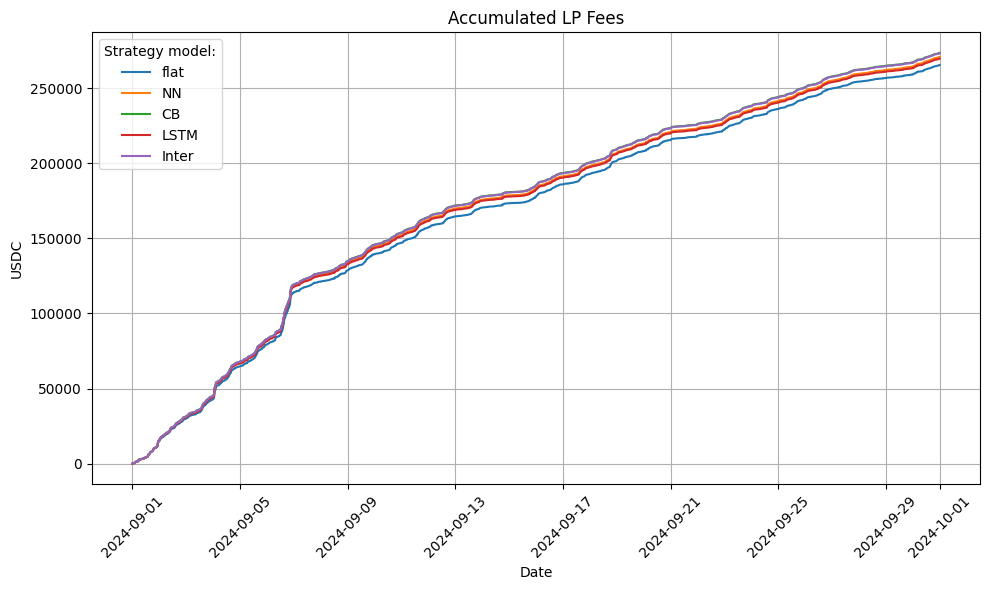

In [ ]:
plt.figure(figsize=(10, 6))

for column in noR_oot_df.iloc[:,-combined_str.shape[0]:].columns:
    plt.plot(df_oot.index[1:], noR_oot_df.iloc[1:,:][column].cumsum(), label=column)

plt.xlabel('Date')
plt.ylabel('USDC')

plt.title('Accumulated LP Fees')
plt.legend(title = "Strategy model:")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()